In [2]:
import numpy as np
from numpy import genfromtxt
import csv
import os

import pysindy as ps

import deepSI
from deepSI import System_data

import matplotlib.pyplot as plt


c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_PATH = r"data\\"

WIENER = "WienerHammerBenchmark"
SILVER = "SNLS80mV"
# SILVER = "Schroeder80mV"
# change data set
DATA = SILVER
CSV = ".csv"

PATH = os.path.join(DATA_PATH, DATA+CSV)

# load data
data = genfromtxt(PATH, delimiter=",")

In [4]:
data = data[1:,:-1] # snl
# data = data[1:,2:-1] # schroeder

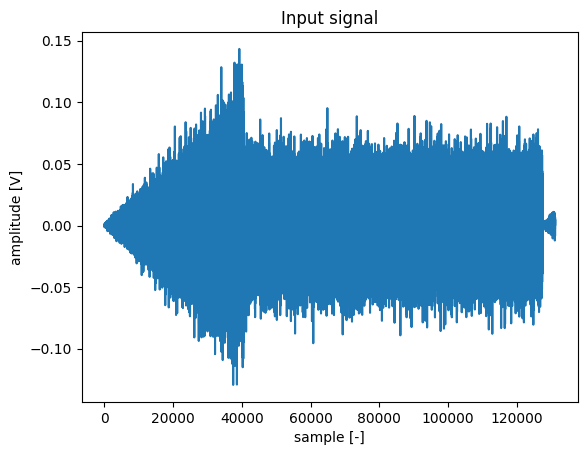

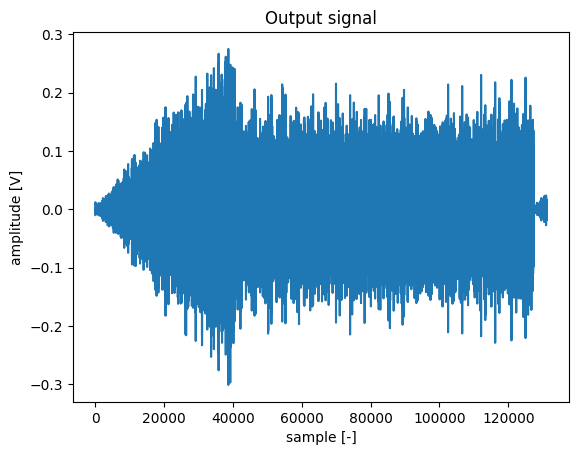

In [5]:
# data
V1 = data[:,0]
V2 = data[:,1]

N = V1.shape[0]
fs = 610.35
dt = 1/fs
t = np.linspace(0,dt*N,N)

plt.plot(V1-np.mean(V1))
plt.xlabel("sample [-]")
plt.ylabel("amplitude [V]")
plt.title("Input signal")
plt.show()

plt.plot(V2-np.mean(V2))
plt.xlabel("sample [-]")
plt.ylabel("amplitude [V]")
plt.title("Output signal")
plt.show()

In [6]:
arrow_head_idx = [i for i in range(0,40000)]
train_idx = [i for i in range(40600,V1.shape[0])]

In [7]:
silver_data = System_data(u=V1[train_idx],y=V2[train_idx])

train, test = silver_data.train_test_split(split_fraction=0.2)
print("Training samples: ", train.y.shape[0])
print("Test samples: ", test.y.shape[0])

time = t[0:train.y.shape[0]]

Training samples:  72377
Test samples:  18095


In [8]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

In [27]:
x_train = train.y

# model specs
feature_library = ps.ConcatLibrary([ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),


stlsq_optimizer = ps.STLSQ(alpha=12, verbose=True)#, threshold= 0.03
# # stlsq_optimizer = ps.SR3(nu=0.08, thresholder="l1", verbose=True, max_iter=1000000)#, threshold= 0.03
# # stlsq_optimizer = ps.TrappingSR3(verbose=True)
# # stlsq_optimizer = ps.SSR(alpha=0.5, kappa=0.5, verbose=True)

model = ps.SINDy(feature_library=feature_library,
                 optimizer=stlsq_optimizer
                 )

time = np.linspace(0,dt*train.y.shape[0],train.y.shape[0])

# fit
model.fit(x_train[:500], u=train.u[:500], t=dt)
model.print()
model.coefficients()

x_test = test.y
x_dot_test_predicted = model.predict(x_test, u=test.u)

time = np.linspace(0,dt*test.y.shape[0],test.y.shape[0])
x_dot_test_simulated = model.simulate([test.y[0]], u=test.u[:500], t=time[:500])


 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 2.4228e+05 ... 3.5028e+02 ...          3 ... 2.4263e+05
         1 ... 2.4228e+05 ... 3.4702e+02 ...          3 ... 2.4263e+05
(x0)' = -14.639 x0 + 252.232 u0 + 2041.930 x0 u0


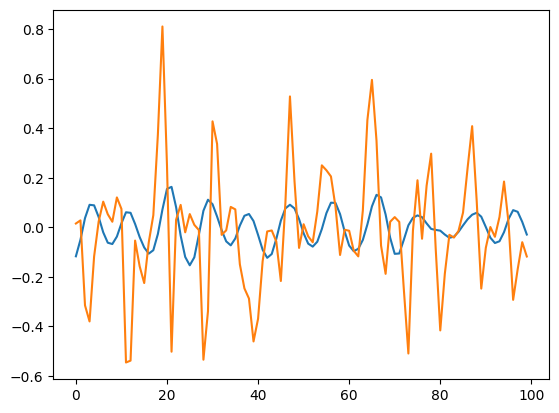

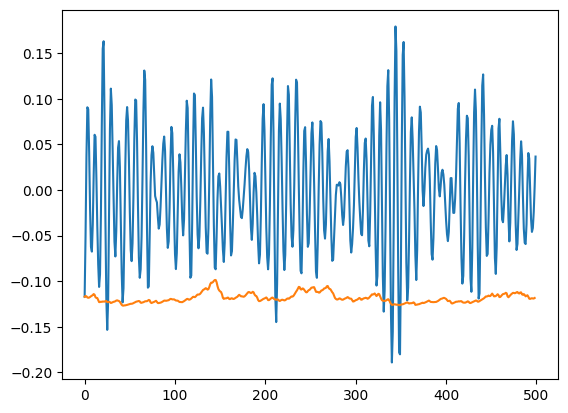

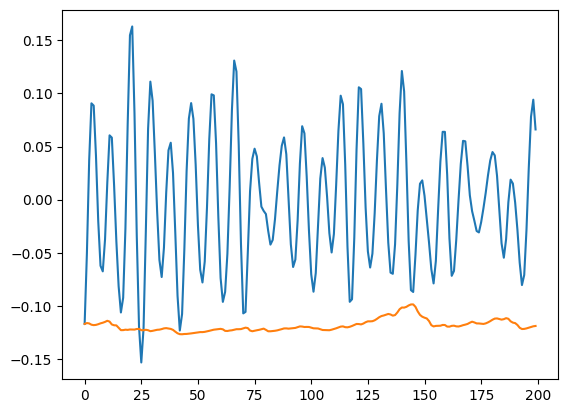

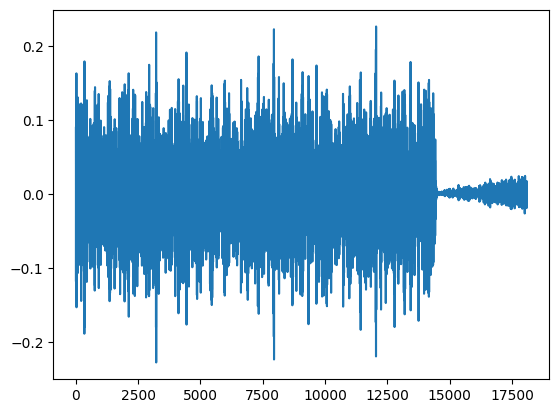

In [18]:
plt.plot(test.y[0:100])
plt.plot(x_dot_test_predicted[:100])
plt.show()

plt.plot(test.y[0:500])
plt.plot(x_dot_test_simulated[0:500])
plt.show()

plt.plot(test.y[0:200])
plt.plot(x_dot_test_simulated[0:200])
plt.show()

plt.plot(test.y)
plt.show()

In [ ]:
pred_NRMS = NRMS( x_dot_test_predicted[:-1,0], test.y[1:])
simo_NRMS = NRMS( x_dot_test_simulated[:,0], test.y[:-1])

print("NRMS pred 1: ",pred_NRMS)
print("NRMS simo 1: ",simo_NRMS)

plt.plot(test.y)
plt.plot(x_dot_test_predicted[:-1,0]-test.y[1:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(test.y)
plt.plot(x_dot_test_simulated[:,0]-np.mean(x_dot_test_simulated[:,0])-test.y[:-1])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()

ValueError: operands could not be broadcast together with shapes (499,) (18094,) 

In [ ]:
arrow_head_data = System_data(u=V1[arrow_head_idx],y=V2[arrow_head_idx])
_, arrow_test = arrow_head_data.train_test_split(split_fraction=1.0)

x_arrow_test = np.stack((arrow_test.y, differentiation_method(arrow_test.y)), axis=-1)

x_arrow_predicted = model.predict(x_arrow_test, u=arrow_test.u)
x_arrow_simulated = model.simulate(x_arrow_test[0], u=arrow_test.u, t=arrow_test.u.shape[0])

pred_NRMS = NRMS( x_arrow_predicted[:-1,0], arrow_test.y[1:])
simo_NRMS = NRMS( x_arrow_simulated[:,0], arrow_test.y[:])

print("NRMS pred 1: ",pred_NRMS)
print("NRMS simo 1: ",simo_NRMS)

NRMS pred 1:  0.031680835033895224
NRMS simo 1:  0.4364512778598333


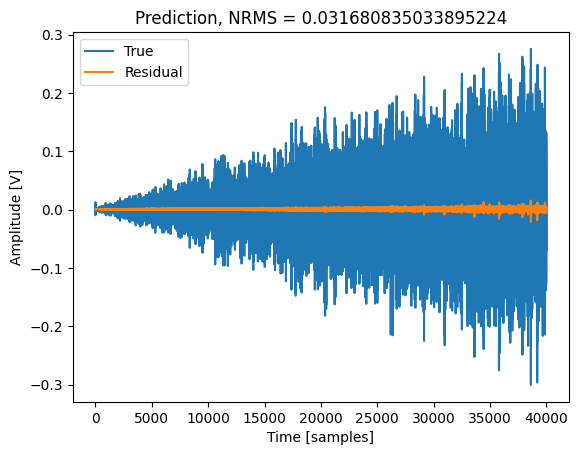

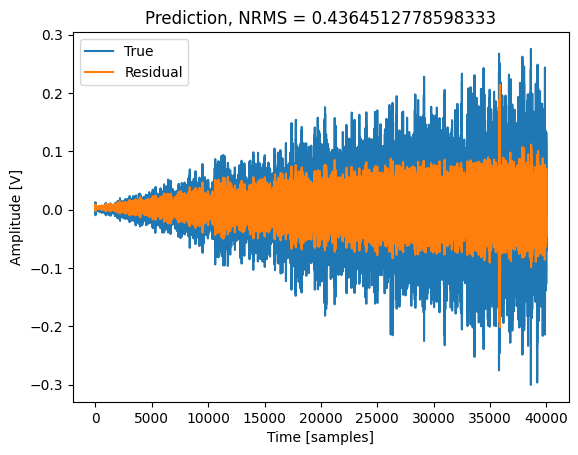

In [ ]:
plt.plot(arrow_test.y)
plt.plot(x_arrow_predicted[:-1,0]-arrow_test.y[1:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(arrow_test.y)
plt.plot(x_arrow_simulated[1:,0]-arrow_test.y[:-1])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()